In [1]:
import os
import json

import cv2
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121, MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
#PATHS
TRAIN_IMGS = '../input/severstal-steel-defect-detection/train_images'
TEST_IMGS = '../input/severstal-steel-defect-detection/test_images/'
TEMP_TRAIN = '../tmp/train'

def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_path(TEMP_TRAIN)

In [3]:
train_df = pd.read_csv('../input/editeddata/maskCount_df.csv')
train_df['noDefect'] = (train_df['hasMask'] == 0).astype(int)

In [4]:
def resize_img(imageid, path, size):
    path = f'{path}/{imageid}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

for imageid in tqdm(train_df['ImageId']):
    img = resize_img(imageid, path = TRAIN_IMGS, size = (256, 256))
    cv2.imwrite(f'{TEMP_TRAIN}/{imageid}', img)

100%|██████████| 12568/12568 [02:18<00:00, 90.80it/s]


In [5]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )
def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_df, 
        directory=TEMP_TRAIN,
        x_col='ImageId', 
        y_col='noDefect', 
        class_mode='raw',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

In [6]:
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')

Found 10683 validated image filenames.
Found 1885 validated image filenames.


In [7]:
def build_model():
    model = Sequential()
    
    model.add(layers.Conv2D(32, (4,4), padding='same', input_shape=(256, 256, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [8]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
__________

In [9]:
total_steps = train_df.shape[0] / BATCH_SIZE

checkpoint = ModelCheckpoint(
    'cls-model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=40,
    callbacks=[checkpoint]
)

Epoch 1/40
334/333 [==============================] - 168s 503ms/step - loss: 0.5555 - acc: 0.7043 - val_loss: 0.8056 - val_acc: 0.5247

Epoch 00001: val_acc improved from -inf to 0.52467, saving model to cls-model.h5
Epoch 2/40
334/333 [==============================] - 157s 469ms/step - loss: 0.4930 - acc: 0.7470 - val_loss: 0.5894 - val_acc: 0.6292

Epoch 00002: val_acc improved from 0.52467 to 0.62918, saving model to cls-model.h5
Epoch 3/40
334/333 [==============================] - 154s 463ms/step - loss: 0.4779 - acc: 0.7593 - val_loss: 0.6216 - val_acc: 0.6674

Epoch 00003: val_acc improved from 0.62918 to 0.66737, saving model to cls-model.h5
Epoch 4/40
334/333 [==============================] - 158s 473ms/step - loss: 0.4600 - acc: 0.7648 - val_loss: 0.3076 - val_acc: 0.8642

Epoch 00004: val_acc improved from 0.66737 to 0.86419, saving model to cls-model.h5
Epoch 5/40
334/333 [==============================] - 155s 465ms/step - loss: 0.4459 - acc: 0.7840 - val_loss: 0.8168 -

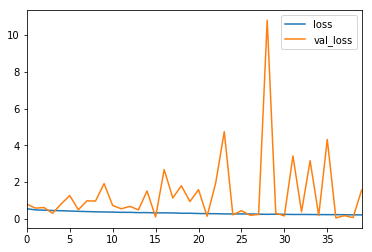

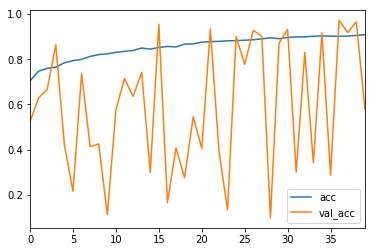

In [10]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()